<h1>Multiple lags, one pre-step on lstm</h1>

<h2>0.Parameters</h2>

In [445]:
LAGS = 3
PRE_STEPS = 1

SEQ_STEPS = 1
FEATURES = 3

TEST_SIZE = 168 * 2
VALIDATION_RATIO = 0.2

DATA_PERIOD = 0 # 0 means 52 wk, 1 means 3 months, 2 means 3 days
REPEATS = 3
EPOCHS = 20
NEURONS = [6]
BATCH_SIZE = 168

input_folder = "../input/electricity/"
#input_file_01 = "elect_250.csv"
input_file_01 = "elect_37.csv"
DEBUG_FOLDER = "../debug/"


In [446]:
input_file_01_path = input_folder + input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../input/electricity/elect_37.csv


<h2>1.Util</h2>

In [447]:
import sys
sys.path.append('../util') # add utility folder to a system path

# The following libs are user-defined ones.
import general_util as gu # time, seed, save_csv
import input_preprocess as ip # split_X_Y, series_to_supervise
#help(ip)
    

In [448]:
start_time = gu.time_start()
gu.set_seed()

<h2>2. Load an input data and preprocess it</h2>

In [449]:
import pandas as pd
series_raw = pd.read_csv(input_file_01_path, encoding = 'CP949', parse_dates=[0], index_col='date')
series_raw.columns = ['elect_sp']
series_raw.head(3)

,elect_sp
date,
2011-01-01 00:15:00,56.290754
2011-01-01 00:30:00,57.899519
2011-01-01 00:45:00,48.802779


In [450]:
# aggregate electric spendings by hour
series = series_raw.resample("H").mean()
#print(series.head())

In [451]:
from datetime import date
print(series.index.weekday) # # 0,1,2,3,4 --> weekday # 5,6 --> weekend
# Get a start and end date
start_date = date(2011,1,3) # Monday
end_date = date(2011,12,25) # Sunday

[5 5 5 ... 2 2 3]


In [452]:
# Make 52 weeks data set, filling hours on empty hour-slots
df_52wk = ip.preprocess_fill_hour(series, start_date, end_date)
file_name = DEBUG_FOLDER + '52_weeks.csv'
gu.save_csv_file(df_52wk, filename=file_name)

In [453]:
# Make 3 months data set
start_date = date(2011,1,3) # Monday
end_date = date(2011,3,27) # Sunday
df_3m = ip.preprocess_fill_hour(series, start_date, end_date)
file_name = DEBUG_FOLDER + '3_months.csv'
gu.save_csv_file(df_3m, filename=file_name)

In [454]:
# Make 3 days data set
start_date = date(2011,1,3) # Monday
end_date = date(2011,1,5) # Sunday
df_3d = ip.preprocess_fill_hour(series, start_date, end_date)
file_name = DEBUG_FOLDER + '3_days.csv'
gu.save_csv_file(df_3d, filename=file_name)

In [455]:
# depending on DATA_PERIOD, the data set is selected
if DATA_PERIOD == 0:
    series = df_52wk
elif DATA_PERIOD == 1:
    series = df_3m
elif DATA_PERIOD == 2:
    series = df_3d
else:
    series = ""
series = series.astype('float32')

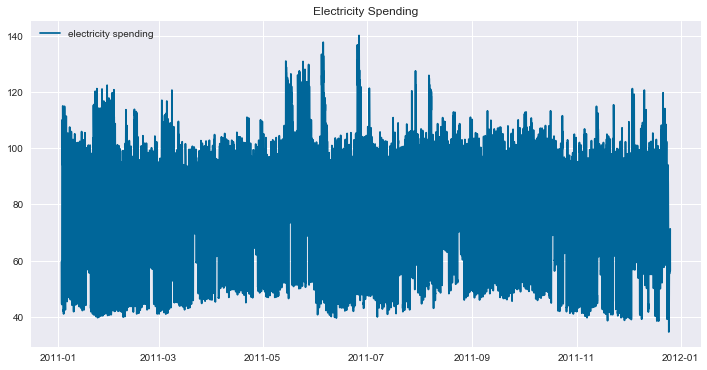

In [456]:
# Show the data set selected
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
plt.rcParams["figure.figsize"] = [12, 6]
plt.plot(series, label="electricity spending", color = '#006699')
plt.legend(loc='upper left')
plt.title("Electricity Spending")
#plt.vlines(date(2017,8,22), color='red', ymin=0, ymax=35, linestyles='dashed')
plt.show()

<h2>3. Scale abd split into train and test</h2>

In [457]:
import math
from sklearn.preprocessing import MinMaxScaler
def prepare_data(series, n_test, val_ratio, n_lag, n_pred, n_batch_size, verbose=False):
    raw_values = series.values
    
    # scale
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    ##### make a supervised form
    supervised = ip.series_to_supervised(scaled_values, n_lag, n_pred, dropnan=True)
    supervised_values_scale = supervised.values
    ##### Split into train and test
    # Get an index of test data set
    test_start_idx = n_test -(n_pred -1)
    train_whole_scale = supervised_values_scale[: -test_start_idx]
    test_scale = supervised_values_scale[-test_start_idx :]
    ##### Split the train into train and val data set
    train_end_idx = math.ceil((train_whole_scale.shape[0] * (1 - val_ratio)))
    train_scale, val_scale = train_whole_scale[0:train_end_idx], train_whole_scale[train_end_idx:]
    
    ##### Get a train data by a multiple of a batch size
    train_len = train_scale.shape[0]
    # Get a multiple of a batch size
    train_end_idx = int(train_len/n_batch_size) * n_batch_size
    train_scale_multiple = train_scale[0:train_end_idx, :]
    
    ##### Get a validation data by a multiple of a batch size
    val_len = val_scale.shape[0]
    # Get a multiple of a batch size
    val_end_idx = int(val_len/n_batch_size) * n_batch_size
    val_scale_multiple = val_scale[0:val_end_idx, :]
    
    ##### Get a train and test raw data
    train_whole_raw_end = -n_test - n_pred + 1
    train_whole_raw, test_raw = raw_values[n_lag : train_whole_raw_end], raw_values[-n_test:]
    train_whole_raw_multiple = train_whole_raw[0:train_whole_raw_end, :]
    
    if verbose:
        print("Shape of train_scale: ", train_scale.shape)
        print("Shape of train_scale_multiple: ", train_scale_multiple.shape)        
        print("Shape of val_scale: ", val_scale.shape)
        print("Shape of val_scale_multiple: ", val_scale_multiple.shape)                
        print("Shape of test_scale: ", test_scale.shape)
        print("Shape of train_whole_raw: ", train_whole_raw.shape)
        print("Shape of train_whole_raw_multiple: ", train_whole_raw_multiple.shape)        
        print("Shape of test_raw: ", test_raw.shape)        
    
    return scaler, train_scale_multiple, val_scale_multiple, test_scale, train_whole_raw_multiple, test_raw



In [458]:
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale, train_raw, test_raw = prepare_data(series, TEST_SIZE,
                                                                               VALIDATION_RATIO,
                                                                               LAGS, PRE_STEPS, 
                                                                               BATCH_SIZE,verbose=True)
y_test = test_raw

Shape of train_scale:  (6584, 4)
Shape of train_scale_multiple:  (6552, 4)
Shape of val_scale:  (1645, 4)
Shape of val_scale_multiple:  (1512, 4)
Shape of test_scale:  (336, 4)
Shape of train_whole_raw:  (8229, 1)
Shape of train_whole_raw_multiple:  (7893, 1)
Shape of test_raw:  (336, 1)


In [459]:
# split X and Y
x_train_scale, y_train_scale = ip.split_X_Y(train_scale, LAGS, "train_scale", verbose=True)
x_val_scale, y_val_scale = ip.split_X_Y(val_scale, LAGS, "val_scale", verbose=True)
x_test_scale, y_test_scale = ip.split_X_Y(test_scale, LAGS, "test_scale", verbose=True)
print("Shape of x_train_scale: ", x_train_scale.shape)
print("Shape of y_train_scale: ", y_train_scale.shape)
print("Shape of x_val_scale: ", x_val_scale.shape)
print("Shape of y_val_scale: ", y_val_scale.shape)
print("Shape of x_test_scale: ", x_test_scale.shape)
print("Shape of y_test_scale: ", y_test_scale.shape)

Shape of x_train_scale:  (6552, 3)
Shape of y_train_scale:  (6552, 1)
Shape of x_val_scale:  (1512, 3)
Shape of y_val_scale:  (1512, 1)
Shape of x_test_scale:  (336, 3)
Shape of y_test_scale:  (336, 1)


<h2>4. make a lstm model and forcast model</h2>

In [460]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

def fit_lstm(X_train, Y_train, X_val, Y_val, n_lag, n_pre_steps, n_seq,  n_feature, n_batch, nb_epoch, n_neurons, 
             verbose=False):

    X_train = X_train.reshape(X_train.shape[0], n_seq, n_feature) # One step and n_lag features
    X_val = X_val.reshape(X_val.shape[0], n_seq, n_feature) # One step and n_lag features
    
    # design network
    history_list = list()
    
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, n_seq, n_feature), stateful=True)) # X.shape[1] as step, X.shape[2] as feature
    model.add(Dense(n_pre_steps)) # pre_steps
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    if verbose:
        print("Shape of X_train in fit_lstm: ", X_train.shape)
        print("Shape of Y_train in fit_lstm: ", Y_train.shape)     
        print("Shape of X_val in fit_lstm: ", X_val.shape)
        print("Shape of Y_val in fit_lstm: ", Y_val.shape)             
        model.summary()
        
    # fit network
    for i in range(nb_epoch):
        if i % 10 == 0:
            print("# of epochs: ", i)
        history = model.fit(X_train, Y_train, epochs=1, batch_size=n_batch, 
                            validation_data=(X_val, Y_val), 
                            verbose=0, shuffle=False) # stateful
        history_list.append(history)
        model.reset_states()
        
    return model, history_list

In [461]:
# Make a forcast model to handle a batch size of 1
def get_forcat_lstm(old_weights, n_lag, n_pre_steps, n_seq,  n_feature, n_neurons, ):
    # re-define the batch size
    n_batch = 1
    # re-define model
    new_model = Sequential()
    new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, n_seq, n_feature), stateful=True))
    new_model.add(Dense(1))
    # copy weights

    new_model.set_weights(old_weights)
    # compile model
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model



In [462]:
# During a learing process, show loss values with a train and validation data
def display_loss_train(history_list):
    # list all data in history
    print("length of history_list: ", len(history_list))  
    
    train_loss = list()
    validation_loss = list()
    for history in history_list:
        #print("history.history: ", history.history)
        train_loss.append(history.history['loss'])
        validation_loss.append(history.history['val_loss'])
        
    # summarize history for accuracy

    plt.plot(train_loss)
    plt.plot(validation_loss,color='red')
    plt.title('model accuracy')
    plt.ylabel('mse accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()    

<h2>5. forcasting functions</h2>

In [463]:
# make forcasts
def make_forecasts(model, n_batch, test_X, n_lag, n_seq, n_features, verbose=False):
    forecasts = list()
    for i in range(0, len(test_X), n_batch):
        X = test_X[i:i + n_batch]
        forecast = forecast_lstm(model, X, n_batch, n_seq, n_features, verbose)
        
        if verbose:
            print("forecast: \n", forecast)
            
        forecasts.append(forecast)
    return forecasts

In [464]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch, n_seq, n_features,  verbose=False):
    if verbose:
        print("X shape in forcast: " , X.shape)
    
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(n_batch, n_seq, n_features)
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    
    if verbose:
        print("forecast shape in forcast : " , forecast.shape)

    return forecast

In [465]:
import math
from sklearn.metrics import mean_squared_error
def evaluate(true_value, predict, verbose=False):
    mse = mean_squared_error(true_value, predict)
    return mse

def invert_scale(scaler, yhat, verbose=False):
    output_item = np.array(yhat).reshape(1,1)
    invert_output = scaler.inverse_transform(output_item)
    invert_output = np.squeeze(invert_output)
    return invert_output

def convert_prediction(scaler, output, lags, pre_step, verbose=True):
    prediction_list = list()
    prediction_step_list = list()
    
    for i in range(pre_step):
        for j in range(len(output)):
            output_item = output[j,i]
            invert_output = invert_scale(scaler, output_item, verbose=False)
            prediction_step_list.append(invert_output)
        prediction_list.append(prediction_step_list)
        prediction_step_list = list()
        
    prediction_list = np.array(prediction_list)
    prediction_list = prediction_list.reshape(prediction_list.shape[1], prediction_list.shape[0])
    
    return prediction_list

<h2>6. Experiment</h2>

In [466]:
import prediction as pred
import numpy as np


In [467]:
def experiment(repeats, nb_epochs, lags, pre_steps, n_seq, n_features, neurons,scaler, 
               x_train_scale, y_train_scale, x_val_scale, y_val_scale,
              x_test_scale, y_test_raw, batch_size=168, verbose=False):
    error_scores = list()
    best_predictions = list()
    best_error_score = 9999.0
    best_history_list = list()
    
    for r in range(repeats):
        model, train_history_list = fit_lstm(x_train_scale, y_train_scale, x_val_scale, y_val_scale,
                                             lags, pre_steps, n_seq, n_features, batch_size, 
                                             nb_epochs, neurons, verbose=True)

        old_weights = model.get_weights()    
        forcast_model = get_forcat_lstm(old_weights, lags, 
                                        pre_steps, n_seq,  n_features, neurons)
        forcast_batch_size = 1
        forecasts_scale = make_forecasts(forcast_model, forcast_batch_size, 
                                         x_test_scale, lags, n_seq, n_features, verbose=False)
        # convert to np array
        forecasts_scale_np = np.array(forecasts_scale)
        # convert to 2d from 3d
        forcast_row_shape = forecasts_scale_np.shape[0] * forecasts_scale_np.shape[1]
        forcast_col_shape = forecasts_scale_np.shape[2]
        forecasts_scale_2d_np = forecasts_scale_np.reshape(forcast_row_shape, forcast_col_shape)
        
        predictions = convert_prediction(scaler, forecasts_scale_2d_np, lags, pre_steps, verbose=True)
        #predictions = convert_prediction(scaler, predict_scale, lags, pre_step, verbose=True)
        test_idx_list = pred.make_mul_index(mul=pre_steps, lens = len(predictions))
        y_test_true = y_test_raw
        
        unique_predict = predictions[test_idx_list]
        unique_predict_vector = unique_predict.reshape(-1,1)
        
        if verbose:
            print("Shape of forecasts_scale: ",len(forecasts_scale))            
            print("forecasts_scale: \n",forecasts_scale[0:8])
            print("Shape of forecasts_scale_np: ", forecasts_scale_np.shape)            
            print("Shape of forecasts_scale_2d_np: ", forecasts_scale_2d_np.shape)
            print("forecasts_scale_2d_np: ", forecasts_scale_2d_np[0:8])            
            print("predictions: \n",predictions[0:8])

        mse = evaluate(y_test_true, unique_predict_vector, verbose=False)
        rmse = math.sqrt(mse)
        print('%d) TEST RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        if best_error_score > rmse:
            best_error_score = rmse
            best_predictions = unique_predict_vector
            best_history_list = train_history_list
                
    return error_scores, best_error_score, best_predictions, y_test_true, best_history_list

Shape of X_train in fit_lstm:  (6552, 1, 3)
Shape of Y_train in fit_lstm:  (6552, 1)
Shape of X_val in fit_lstm:  (1512, 1, 3)
Shape of Y_val in fit_lstm:  (1512, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (168, 6)                  240       
_________________________________________________________________
dense_83 (Dense)             (168, 1)                  7         
Total params: 247
Trainable params: 247
Non-trainable params: 0
_________________________________________________________________
# of epochs:  0
# of epochs:  10
1) TEST RMSE: 15.248
Shape of X_train in fit_lstm:  (6552, 1, 3)
Shape of Y_train in fit_lstm:  (6552, 1)
Shape of X_val in fit_lstm:  (1512, 1, 3)
Shape of Y_val in fit_lstm:  (1512, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)        

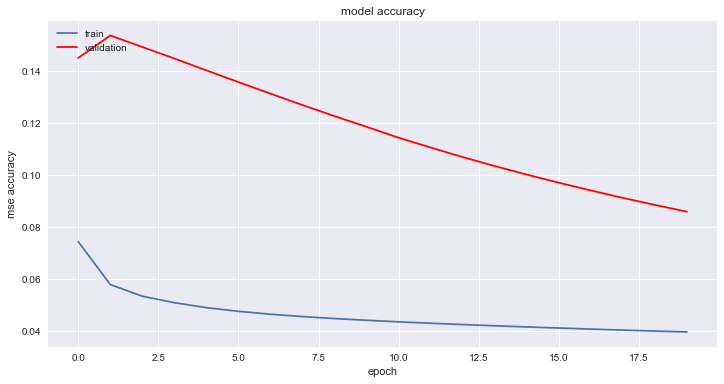

               6
count   3.000000
mean   15.754354
std     1.218623
min    14.870644
25%    15.059260
50%    15.247876
75%    16.196209
max    17.144541


In [468]:
results = pd.DataFrame()
best_error_score = 9999
best_predictions = list()
best_history_list = list()

for e in NEURONS:
    results[str(e)], error_score, predictions, y_test_true, train_history_list = experiment(REPEATS, 
                                                                                            EPOCHS, LAGS, PRE_STEPS, SEQ_STEPS,FEATURES,e,scaler,x_train_scale, y_train_scale,x_val_scale, y_val_scale, x_test_scale, y_test,BATCH_SIZE, verbose=False)
    if best_error_score > error_score:
        best_error_score = error_score
        best_predictions = predictions
        best_history_list = train_history_list
        
        
display_loss_train(best_history_list)
print(results.describe())



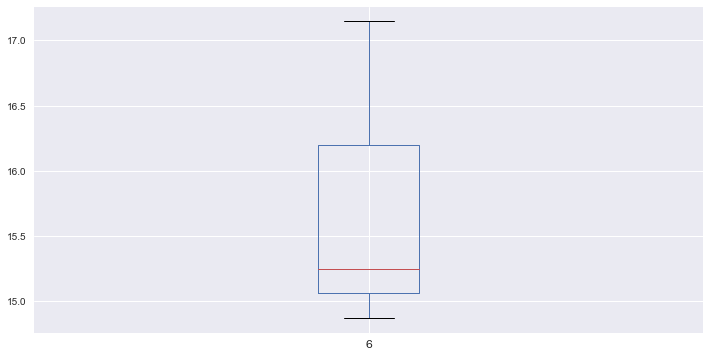

In [469]:
results.boxplot()
plt.show()

<h2>6. Evaluation</h2>

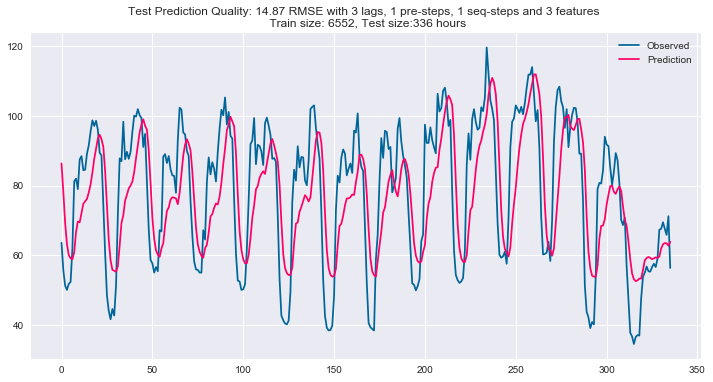

In [470]:
plt.title("Test Prediction Quality: {:.2f} RMSE with {} lags, {} pre-steps, {} seq-steps and {} features \n Train size: {}, Test size:{} hours".
         format(best_error_score, LAGS, PRE_STEPS,SEQ_STEPS, FEATURES, len(x_train_scale), TEST_SIZE))
plt.plot(y_test_true, label = 'Observed', color='#006699')
plt.plot(best_predictions, label='Prediction', color='#ff0066')
plt.legend(loc='best')
plt.show()

In [471]:
gu.time_end(start_time)

start time:  1531555177.941746
end time:  1531555245.123397
Total exectution time (Min): 1.119694185256958


<h3>Reference:</h3><br>